In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split

import torchvision

import matplotlib.pyplot as plt 
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\hany5\AppData\Local\Temp\ipykernel_14204\3685726550.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
cdata = torchvision.datasets.EMNIST(root='emnist', split='letters',download=True)

In [4]:
print(cdata.classes,f'{len(cdata.classes)} classes')
print(f'shape: {cdata.data.shape}')

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 27 classes
shape: torch.Size([124800, 28, 28])


*Notes*
cdata is the EMNIST class itself, it has new different methods to be learned and accustomed to, images is where the data is, the pictures.
labels is where we put the labels (being targets)

In [5]:
#the data is is 124800 samples, 28x28 and grayscale, we need to reshape it and show the dimension for the grayscale, hence 1
#and transform the data from int8 to float
images = cdata.data.view([124800,1,28,28]).float()
print(images.shape)

torch.Size([124800, 1, 28, 28])


In [6]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
#we start preprocessing, first we deal with the null values

print(torch.sum(cdata.targets==0))
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [8]:
#substracting the first category 0 as it refers to N/A
letterCategories = cdata.classes[1:]
# we notice there were no elements linked to the category N/A but we need to get rid of it regardless bc of the size of the targets
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)
print(torch.sum(labels==0))
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [9]:
images[0].shape

torch.Size([1, 28, 28])

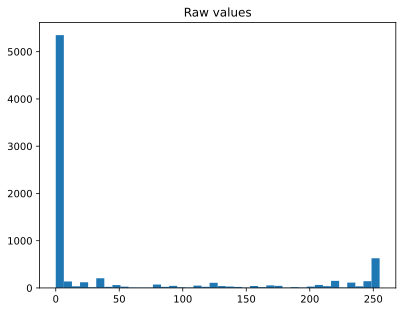

In [10]:
# Code to check out whether or not we need to normalize the images
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

images /= torch.max(images)

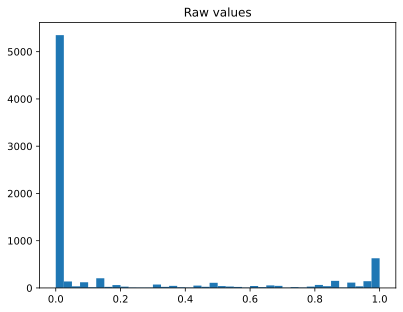

In [11]:
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

In [12]:
#Split the data
train_data,test_data, train_labels,test_labels = train_test_split(images,labels,test_size=0.2)
#convert into pytorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
#Dataloader 
batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([99840, 1, 28, 28])
torch.Size([99840])


32 is the batchsize, hence flattening will flatten all the 32 pictures into one 1D tensor

In [14]:
#Creating the model Class

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.batch1 = nn.BatchNorm2d(6)
        #output size: ((28+2*2-5)/1)+1 = 28, 28/2 = 14; (maxpooling kernelsize of 2 and stride 1, divides the output to two)

        self.conv2 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=5,padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.batch2 = nn.BatchNorm2d(6)
        #output size: 7; same calcul as above

        self.fc1 = nn.Linear(7*7*6,50)
        self.fc2 = nn.Linear(50,26)

    def forward(self,x):
            #first block
            x = torch.relu(self.conv1(x))
            x = self.maxpool1(x)
            x = self.batch1(x)
            #second block
            x = torch.relu(self.conv2(x))
            x = self.batch2(self.maxpool2(x))
            #third block (reshaping for linear: Flatten)
            x = x.view(x.size(0),-1)
            #final block: Linear layers
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)

            return x

In [15]:
model = CNN()

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [17]:
#main loop to train the model

n_epochs = 10
model.to(device)
trainloss = []
testloss = []


for epoch in range(n_epochs):
    print(f"epoch {epoch}")
    model.train()
    batchloss = []
    s_batchloss = []
    for x,y in train_loader:
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batchloss.append(loss.item())
    trainloss.append(np.mean(batchloss))
    print(f"training_loss: {trainloss[epoch]}")
    for x_test,y_test in test_loader:
        x_test,y_test = x_test.to(device),y_test.to(device)
        yhat = model(x_test)
        loss = criterion(yhat,y_test)
        s_batchloss.append(loss.item())
    testloss.append(np.mean(s_batchloss))
    print(f"testing_loss: {testloss[epoch]}")
    

epoch 0
training_loss: 0.5149062444133541
testing_loss: 0.3221273422241211
epoch 1
training_loss: 0.2906271555007268
testing_loss: 0.2900674641132355
epoch 2
training_loss: 0.2543977729313505
testing_loss: 0.26036643981933594
epoch 3
training_loss: 0.23371567771328278
testing_loss: 0.25629302859306335
epoch 4
training_loss: 0.21972510762876854
testing_loss: 0.2458883374929428
epoch 5
training_loss: 0.20848112596103396
testing_loss: 0.24853885173797607
epoch 6
training_loss: 0.2005688949750784
testing_loss: 0.24186286330223083
epoch 7
training_loss: 0.1929990032372865
testing_loss: 0.23365090787410736
epoch 8
training_loss: 0.18623690250514743
testing_loss: 0.24700018763542175
epoch 9
training_loss: 0.18080719912466472
testing_loss: 0.22557935118675232
